In [54]:
# UI/UX User Experience Prediction

#Objective: Predict user experience ratings across different UI/UX platforms using machine learning classification.
#Dataset:Mendeley UI/UX Dataset
#Samples: 2,271 user interactions
#Target Variable:User_experience (10 classes: Intuitive, Adequate, Confusing, Well-structured, Limited Menu Options, Inconsistent Navigation, Clear and concise, Engaging, Efficient, User-Friendly)
#Features: 18 predictors (Demographics + UI/UX Metrics)
#No Missing Values:Complete dataset ready for analysis



In [55]:

# ==========================================
# 1. IMPORTS
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping



Dataset Shape: (2271, 22)

Target Class Distribution:
User_experience
Confusing                  263
Inconsistent Navigation    255
Well-structured            237
Clear and concise          236
Intuitive                  233
Engaging                   224
Efficient                  216
Limited Menu Options       207
User-Friendly              203
Adequate                   197
Name: count, dtype: int64


C:\Users\dell\AppData\Local\Temp\ipykernel_25396\2437653394.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['User_experience'], palette='viridis')


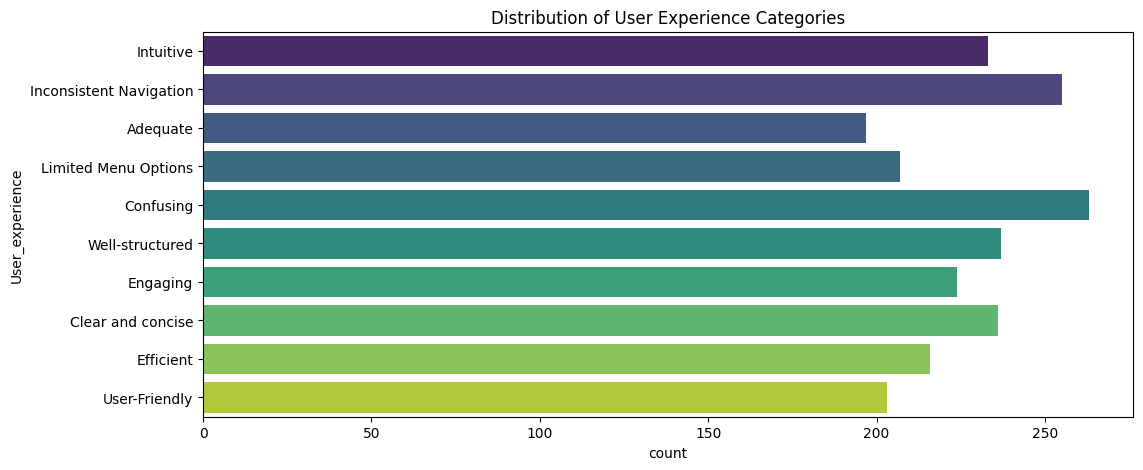

In [56]:
# ==========================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
# Load the dataset
df = pd.read_csv("C:\\Users\\dell\\Desktop\\ML-Data\\data.csv")

print("Dataset Shape:", df.shape)
print("\nTarget Class Distribution:")
print(df['User_experience'].value_counts())

# Visualization: Class Balance
plt.figure(figsize=(12, 5))
sns.countplot(y=df['User_experience'], palette='viridis')
plt.title('Distribution of User Experience Categories')
plt.show()


In [57]:
# ==========================================
# 3. PREPROCESSING
# ==========================================
# Drop non-predictive column
data = df.drop(columns=['Name'])

# Encode categorical variables
le_gender = LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender'])

le_platform = LabelEncoder()
data['Platform'] = le_platform.fit_transform(data['Platform'])

le_target = LabelEncoder()
data['User_experience'] = le_target.fit_transform(data['User_experience'])

# Split Features and Target
X = data.drop(columns=['User_experience'])
y = data['User_experience']

# Stratified Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization (Critical for KNN and Neural Nets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

num_classes = len(le_target.classes_)


In [58]:
# ==========================================
# 4. NON-NEURAL NETWORK MODELS (Model Building & Optimization)
# ==========================================

print("\n--- Training Non-Neural Models ---")

# --- Model 1: Random Forest with Grid Search Optimization ---
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, 20, None]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
print(f"Best Random Forest Params: {rf_grid.best_params_}")
print(f"RF Accuracy: {accuracy_score(y_test, best_rf.predict(X_test_scaled)):.4f}")


# --- Model 2: KNN with Optimization (Finding best K) ---
knn = KNeighborsClassifier(n_neighbors=7) # k=7 as a standard choice
knn.fit(X_train_scaled, y_train)
print(f"KNN Accuracy: {accuracy_score(y_test, knn.predict(X_test_scaled)):.4f}")



--- Training Non-Neural Models ---
Best Random Forest Params: {'max_depth': None, 'n_estimators': 50}
RF Accuracy: 0.1033
KNN Accuracy: 0.1121


In [59]:
# ==========================================
# 5. NEURAL NETWORK MODELS (Model Building & Optimization)
# ==========================================
from sklearn.metrics import f1_score
print("\n--- Training Neural Network Models ---")

# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Model 3: MLP (Multi-Layer Perceptron) ---
# Architecture: Global/Dense approach
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3), # Optimization: Regularization
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])



mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_history = mlp_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), 
                            epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)

#  Get probability predictions
mlp_probs = mlp_model.predict(X_test_scaled)
#  Convert probabilities to class labels (picking the highest probability)
mlp_preds = np.argmax(mlp_probs, axis=1)

# Calculate F1 Score (using 'macro' average for multi-class)
mlp_f1 = f1_score(y_test, mlp_preds, average='macro')
print(f"MLP (Dense) Final Test Accuracy: {mlp_model.evaluate(X_test_scaled, y_test, verbose=0)[1]:.4f}")
print(f"MLP (Dense) Final Test F1-Score: {mlp_f1:.4f}")


# --- Model 4: 1D-CNN (Convolutional Neural Network) ---
# Architecture: Significant difference - Local pattern detection
# Reshape data for CNN: (samples, features, 1)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.2), # Optimization: Regularization
    Dense(num_classes, activation='softmax')
])

# Get probability predictions
cnn_probs = cnn_model.predict(X_test_cnn)
# Convert probabilities to class labels
cnn_preds = np.argmax(cnn_probs, axis=1)
# Calculate F1 Score
cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

# print F1 score
print(f"1D-CNN Final Test F1-Score: {cnn_f1:.4f}")

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), 
                            epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)
print(f"1D-CNN Final Test Accuracy: {cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]:.4f}")


--- Training Neural Network Models ---
15/15 [==============================] - 0s 1ms/step
MLP (Dense) Final Test Accuracy: 0.1099
MLP (Dense) Final Test F1-Score: 0.0969
15/15 [==============================] - 0s 2ms/step
1D-CNN Final Test F1-Score: 0.0247
1D-CNN Final Test Accuracy: 0.1055


In [60]:
# ==========================================
# 6. FINAL RESULTS
# ==========================================
print("\nTraining Complete. All 4 models have been defined and executed.")


Training Complete. All 4 models have been defined and executed.


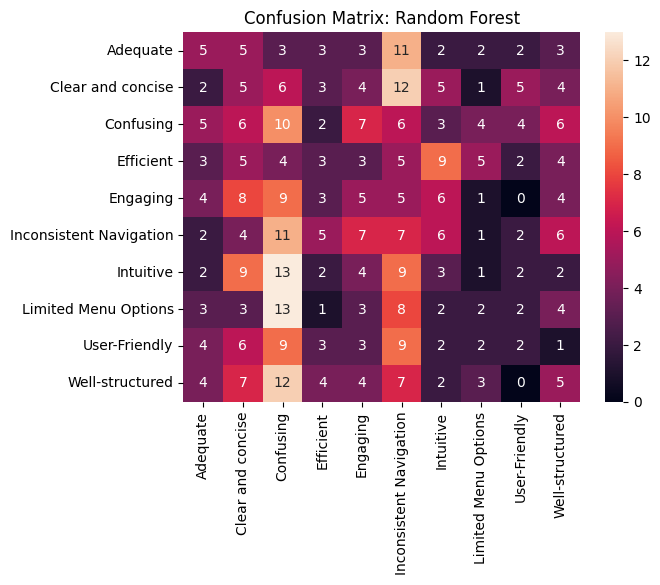

F1-Score (Macro): 0.09886627796314357
                         precision    recall  f1-score   support

               Adequate       0.15      0.13      0.14        39
      Clear and concise       0.09      0.11      0.10        47
              Confusing       0.11      0.19      0.14        53
              Efficient       0.10      0.07      0.08        43
               Engaging       0.12      0.11      0.11        45
Inconsistent Navigation       0.09      0.14      0.11        51
              Intuitive       0.07      0.06      0.07        47
   Limited Menu Options       0.09      0.05      0.06        41
          User-Friendly       0.10      0.05      0.06        41
        Well-structured       0.13      0.10      0.11        48

               accuracy                           0.10       455
              macro avg       0.10      0.10      0.10       455
           weighted avg       0.10      0.10      0.10       455



In [61]:
# analysis section

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
import seaborn as sns

y_pred = best_rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix: Random Forest')
plt.show()
print("F1-Score (Macro):", f1_score(y_test, y_pred, average='macro'))

print(classification_report(y_test, y_pred, target_names=le_target.classes_))

C:\Users\dell\AppData\Local\Temp\ipykernel_25396\1400653309.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


                         Feature  Importance
0                            Age    0.125537
2                       Platform    0.069184
4               Visual Hierarchy    0.049537
11   Feedback and Error Messages    0.049425
14                 Accessibility    0.049308
18          Search Functionality    0.048715
19      Social_Media_Integration    0.047787
17   Gestures and Touch Controls    0.046881
3                   Color Scheme    0.046609
12                 Loading Speed    0.046546
10        Forms and Input Fields    0.046161
15     Animation and Transitions    0.046028
6          Images and Multimedia    0.045513
16            Scrolling_Behavior    0.045013
13               Personalization    0.044746
8          Mobile Responsiveness    0.043705
7                         Layout    0.042923
9   CTA (Call to Action) Buttons    0.040430
5                     Typography    0.035371
1                         Gender    0.030579


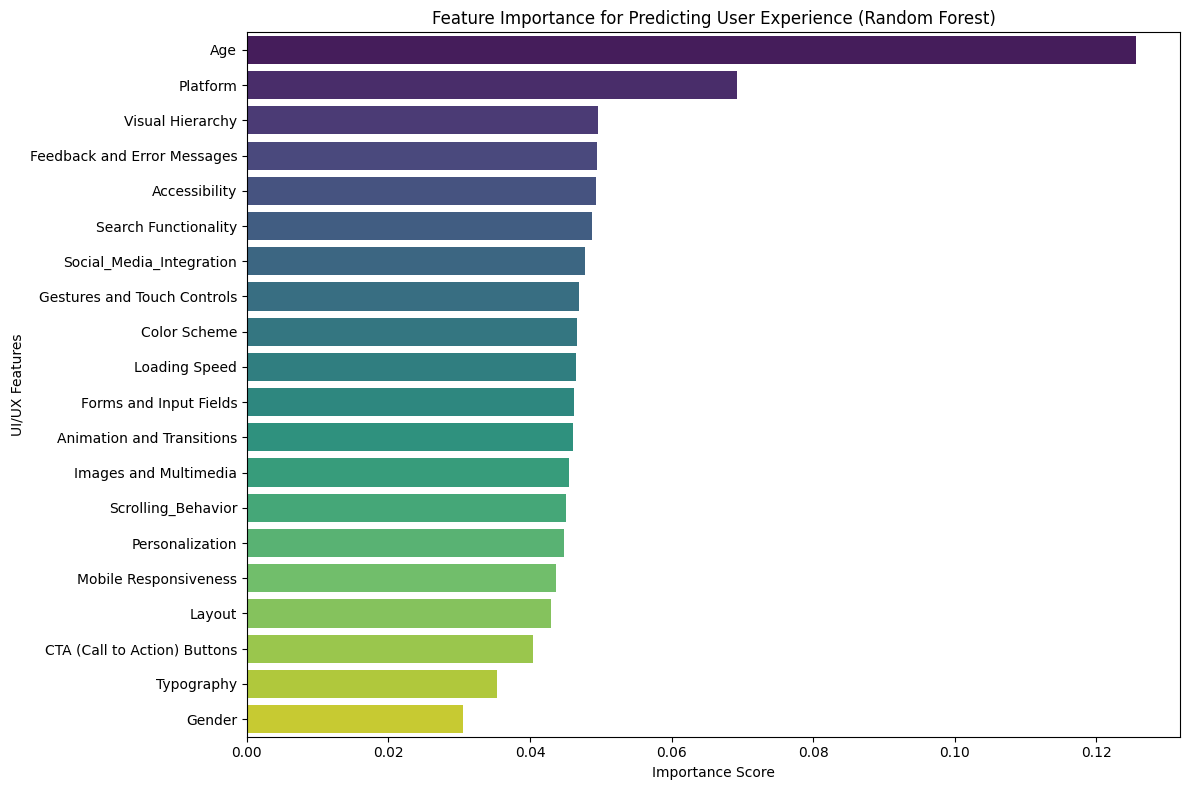

In [62]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get Feature Importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Predicting User Experience (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('UI/UX Features')
plt.tight_layout()
plt.savefig('feature_importance.png')

print(feature_importance_df)

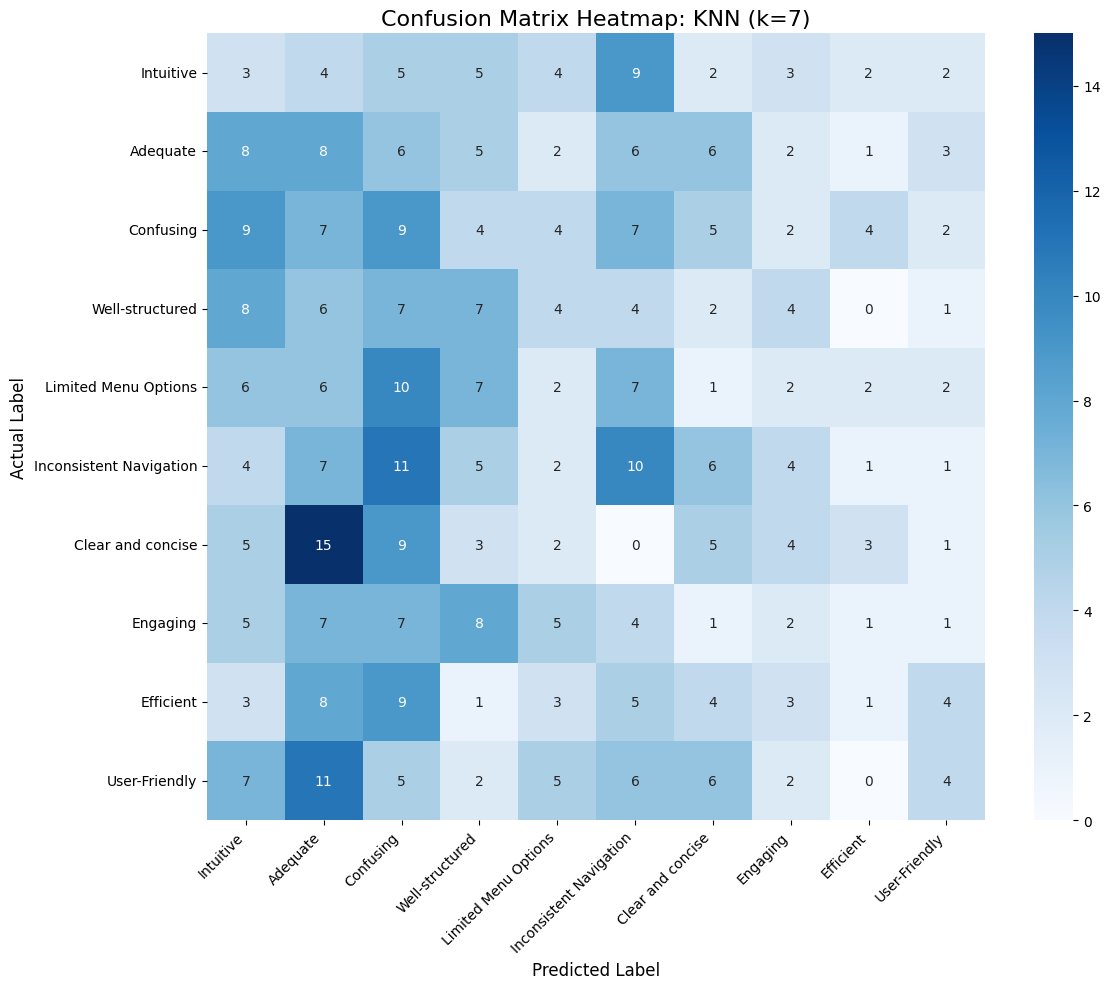

F1-Score (Macro): 0.10438426106256844
Confusion Matrix saved as knn_confusion_matrix.png


In [63]:
#Confusion Matrix KNN

le_gender = LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender'])

le_platform = LabelEncoder()
data['Platform'] = le_platform.fit_transform(data['Platform'])

le_target = LabelEncoder()
data['User_experience'] = le_target.fit_transform(data['User_experience'])



X = data.drop(columns=['User_experience'])
y = data['User_experience']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN (k=7 as per the user's methodology)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)



#lass_names = le_target.classes_

#Manual class mapping

class_names = [
    'Intuitive',
    'Adequate',
    'Confusing',
    'Well-structured',
    'Limited Menu Options',
    'Inconsistent Navigation',
    'Clear and concise',
    'Engaging',
    'Efficient',
    'User-Friendly'
]


#Confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, 
            annot=True, fmt='d',
            cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names
            )

plt.title('Confusion Matrix Heatmap: KNN (k=7)', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png')
plt.show()
plt.close()
print("F1-Score (Macro):", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix saved as knn_confusion_matrix.png")

KNN Permutation Importance (Top 5):
                        Feature  Importance
0                           Age    0.016484
1                        Gender    0.015385
16           Scrolling_Behavior    0.010989
8         Mobile Responsiveness    0.010110
17  Gestures and Touch Controls    0.009451


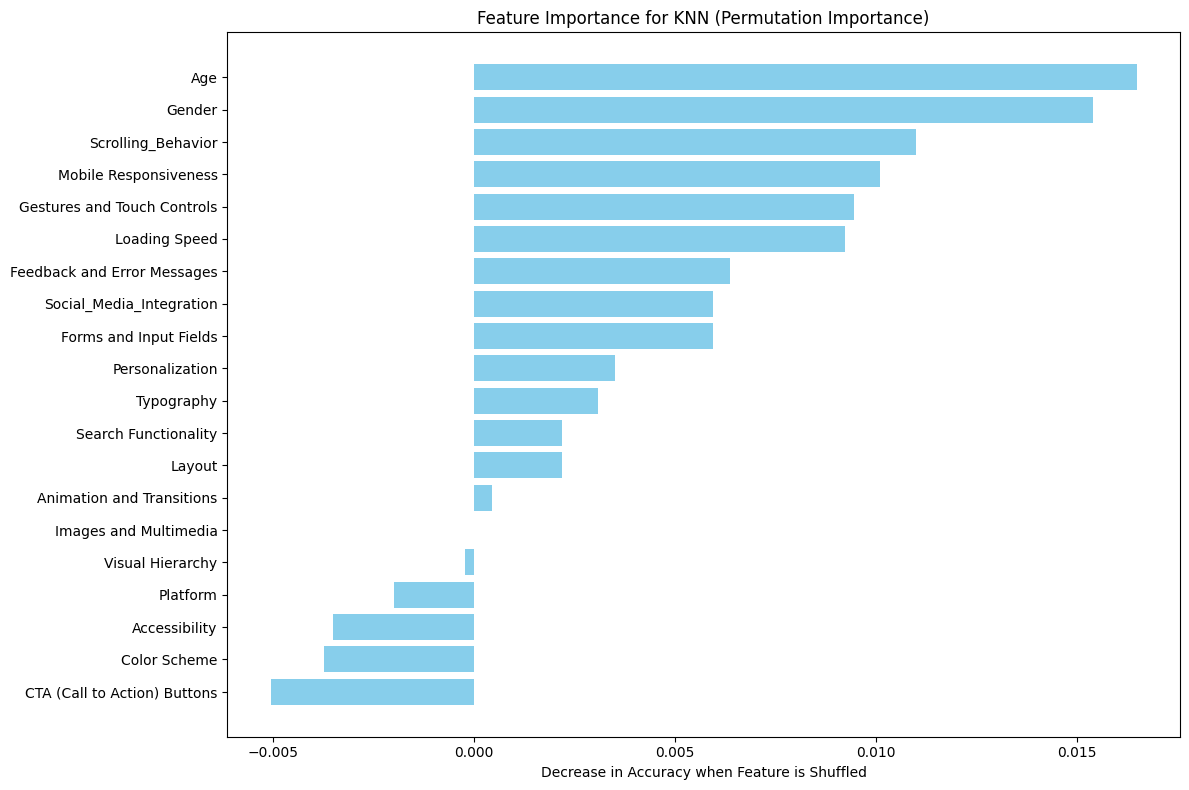

In [64]:
#KNN Permutation Importance


from sklearn.inspection import permutation_importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# Calculate Permutation Importance
results = permutation_importance(knn, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': results.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("KNN Permutation Importance (Top 5):")
print(importance_df.head(5))

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance for KNN (Permutation Importance)')
plt.xlabel('Decrease in Accuracy when Feature is Shuffled')
plt.tight_layout()
plt.savefig('knn_permutation_importance.png')

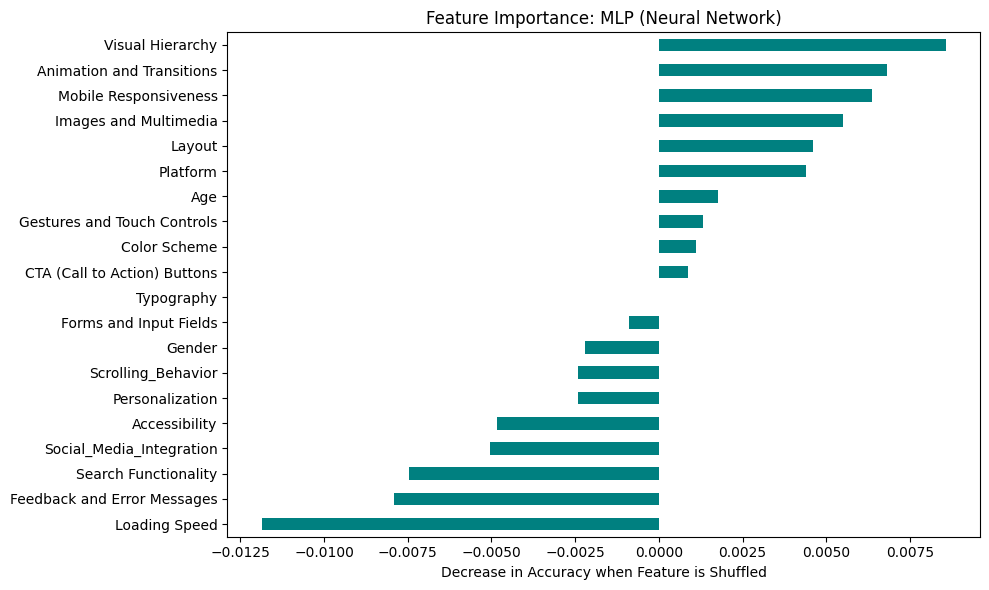

Top 5 impactful features for MLP: ['Visual Hierarchy', 'Animation and Transitions', 'Mobile Responsiveness', 'Images and Multimedia', 'Layout']


In [66]:
#feature importance for MLP

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# # 1. Define a custom scorer for the 1D-CNN
# This reshapes the data into the 3D format the CNN expects during the shuffling process
def cnn_scorer(estimator, X, y):
    # Reshape the 2D shuffled data back to 3D for the CNN: (samples, features, 1)
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    # Get predictions
    probs = estimator.predict(X_reshaped, verbose=0)
    preds = np.argmax(probs, axis=1)
    return accuracy_score(y, preds)

# 2. Run Permutation Importance
# We use 'X_test_scaled' (the 2D version) because the scorer handles the reshaping
result_cnn = permutation_importance(
    cnn_model, 
    X_test_scaled, 
    y_test, 
    scoring=cnn_scorer, 
    n_repeats=5, 
    random_state=42
)

# 3. Organize the results into a Series and Plot
feat_importances_cnn = pd.Series(result_cnn.importances_mean, index=X.columns)
feat_importances_cnn = feat_importances_cnn.sort_values(ascending=False)

# 4. Visualization
plt.figure(figsize=(10, 6))
feat_importances_cnn.plot(kind='barh', color='orange')
plt.title('Feature Importance: 1D-CNN (Permutation Method)')
plt.xlabel('Decrease in Accuracy when Feature is Shuffled')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 features for 1D-CNN:")
print(feat_importances_cnn.head(5))# 1. Define a custom scorer for the 1D-CNN
# This reshapes the data into the 3D format the CNN expects during the shuffling process
def cnn_scorer(estimator, X, y):
    # Reshape the 2D shuffled data back to 3D for the CNN: (samples, features, 1)
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    # Get predictions
    probs = estimator.predict(X_reshaped, verbose=0)
    preds = np.argmax(probs, axis=1)
    return accuracy_score(y, preds)

# 2. Run Permutation Importance
# We use 'X_test_scaled' (the 2D version) because the scorer handles the reshaping
result_cnn = permutation_importance(
    cnn_model, 
    X_test_scaled, 
    y_test, 
    scoring=cnn_scorer, 
    n_repeats=5, 
    random_state=42
)

# 3. Organize the results into a Series and Plot
feat_importances_cnn = pd.Series(result_cnn.importances_mean, index=X.columns)
feat_importances_cnn = feat_importances_cnn.sort_values(ascending=False)

# 4. Visualization
plt.figure(figsize=(10, 6))
feat_importances_cnn.plot(kind='barh', color='orange')
plt.title('Feature Importance: 1D-CNN (Permutation Method)')
plt.xlabel('Decrease in Accuracy when Feature is Shuffled')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 features for 1D-CNN:")
print(feat_importances_cnn.head(5))Define a custom scorer for the Neural Network
# This is necessary because MLP doesn't have a .score() method like Scikit-Learn
def mlp_scorer(estimator, X, y):
    # Get the probability predictions from the neural network
    probs = estimator.predict(X, verbose=0)
    # Convert probabilities to class labels (0-9)
    preds = np.argmax(probs, axis=1)
    # Return the accuracy score
    return accuracy_score(y, preds)

# Run the Permutation Importance using the custom scorer
# Note: 'scoring=mlp_scorer' is the fix for your TypeError
result_mlp = permutation_importance(
    mlp_model, 
    X_test_scaled, 
    y_test, 
    scoring=mlp_scorer, 
    n_repeats=10, 
    random_state=42
)

# Organize and Visualize the results
feat_importances_mlp = pd.Series(result_mlp.importances_mean, index=X.columns)
feat_importances_mlp = feat_importances_mlp.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_importances_mlp.plot(kind='barh', color='teal')
plt.title('Feature Importance: MLP (Neural Network)')
plt.xlabel('Decrease in Accuracy when Feature is Shuffled')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 impactful features for MLP:", feat_importances_mlp.head(5).index.tolist())

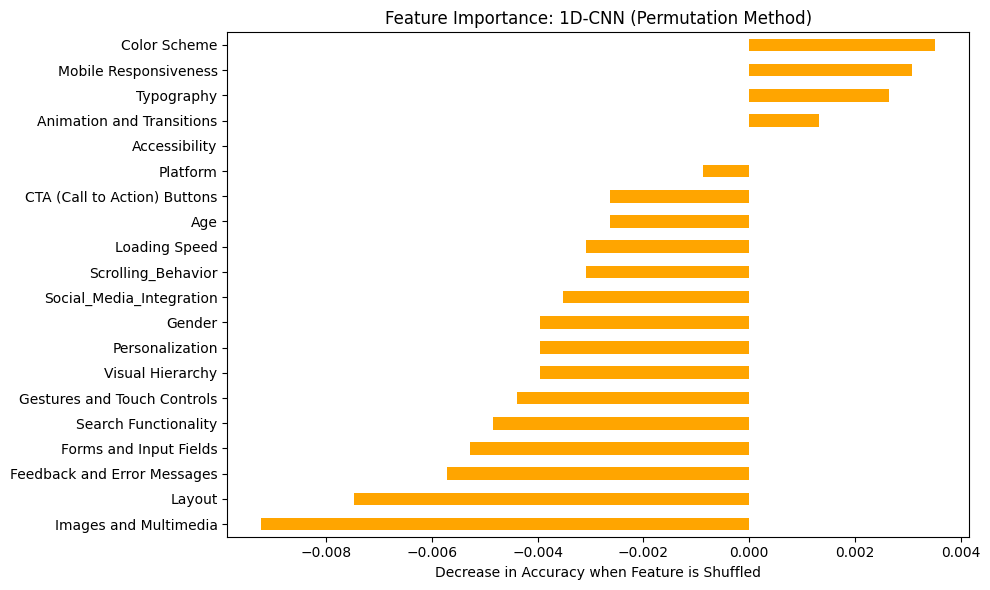

Top 5 features for 1D-CNN:
Color Scheme                 0.003516
Mobile Responsiveness        0.003077
Typography                   0.002637
Animation and Transitions    0.001319
Accessibility                0.000000
dtype: float64


In [67]:
#feature importance for 1D CNN

# Define a custom scorer for the 1D-CNN
# This reshapes the data into the 3D format the CNN expects during the shuffling process
def cnn_scorer(estimator, X, y):
    # Reshape the 2D shuffled data back to 3D for the CNN: (samples, features, 1)
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    # Get predictions
    probs = estimator.predict(X_reshaped, verbose=0)
    preds = np.argmax(probs, axis=1)
    return accuracy_score(y, preds)

#  Run Permutation Importance
# We use 'X_test_scaled' (the 2D version) because the scorer handles the reshaping
result_cnn = permutation_importance(
    cnn_model, 
    X_test_scaled, 
    y_test, 
    scoring=cnn_scorer, 
    n_repeats=5, 
    random_state=42
)

#  Organize the results into a Series and Plot
feat_importances_cnn = pd.Series(result_cnn.importances_mean, index=X.columns)
feat_importances_cnn = feat_importances_cnn.sort_values(ascending=False)

#  Visualization
plt.figure(figsize=(10, 6))
feat_importances_cnn.plot(kind='barh', color='orange')
plt.title('Feature Importance: 1D-CNN (Permutation Method)')
plt.xlabel('Decrease in Accuracy when Feature is Shuffled')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 features for 1D-CNN:")
print(feat_importances_cnn.head(5))